<a href="https://colab.research.google.com/github/Reybolouri/Contest-2-Machine-Learning/blob/main/contest_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --quiet tensorflow xgboost


In [ ]:
!git clone https://github.com/Reybolouri/Contest-2-Machine-Learning.git
%cd Contest-2-Machine-Learning/data

Cloning into 'Contest-2-Machine-Learning'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 14 (delta 3), reused 8 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (14/14), 19.30 MiB | 14.52 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Updating files: 100% (5/5), done.
/content/Contest-2-Machine-Learning/data


In [ ]:
import pandas as pd
import numpy as np

# 2.1 Read the CSVs
train = pd.read_csv('train.csv')
test  = pd.read_csv('test.csv')

print("Train shape:", train.shape)
print("Test shape: ",  test.shape)

# 2.2 Check class balance
print(train['y'].value_counts())

# 2.3 Peek at pixel columns
train.columns[:10]


Train shape: (1200, 3074)
Test shape:  (1200, 3073)
y
2    407
1    402
3    391
Name: count, dtype: int64


Index(['id', 'y', 'r0101', 'r0201', 'r0301', 'r0401', 'r0501', 'r0601',
       'r0701', 'r0801'],
      dtype='object')

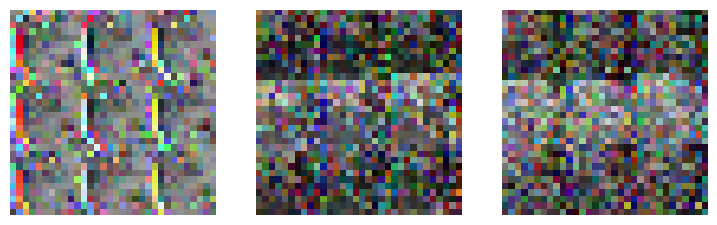

In [ ]:
#test a few samples:
import matplotlib.pyplot as plt

def show_patch(row, ax):
    pix = row.iloc[2:].values.reshape(32,32,3)  # drop id,y
    ax.imshow(pix)
    ax.axis('off')

fig, axes = plt.subplots(1,3, figsize=(9,3))
for i, idx in enumerate([0, 200, 400]):
    show_patch(train.iloc[idx], axes[i])
plt.show()


In [ ]:
#Preprocessing & Train/Val Split
from sklearn.model_selection import train_test_split

# 4.1 Features & labels
X = train.drop(['id','y'], axis=1).values
y = train['y'].values - 1   # shift to 0,1,2

# 4.2 Stratified split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42)

# 4.3 Reshape for CNN
X_train_cnn = X_train.reshape(-1,32,32,3)
X_val_cnn   = X_val.reshape(-1,32,32,3)

print("CNN input shape:", X_train_cnn.shape)


CNN input shape: (960, 32, 32, 3)


In [ ]:
###CNN:

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# 5.1 One-hot encode labels
y_train_cat = tf.keras.utils.to_categorical(y_train, 3)
y_val_cat   = tf.keras.utils.to_categorical(y_val,   3)

# 5.2 Build model
def build_cnn():
    inp = layers.Input((32,32,3))
    x = layers.Conv2D(32,3,activation='relu',padding='same')(inp)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64,3,activation='relu',padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128,activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    out = layers.Dense(3,activation='softmax')(x)
    return models.Model(inp,out)

model = build_cnn()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

# 5.3 Train with EarlyStopping
es = callbacks.EarlyStopping(patience=5, restore_best_weights=True)
hist = model.fit(
    X_train_cnn, y_train_cat,
    validation_data=(X_val_cnn, y_val_cat),
    epochs=50, batch_size=32,
    callbacks=[es]
)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 544,195 (2.08 MB)

 Trainable params: 544,195 (2.08 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.5552 - loss: 0.9112 - val_accuracy: 0.7458 - val_loss: 0.5499
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.7524 - loss: 0.5752 - val_accuracy: 0.8042 - val_loss: 0.4675
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.8109 - loss: 0.4709 - val_accuracy: 0.8375 - val_loss: 0.4010
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.8458 - loss: 0.4330 - val_accuracy: 0.8750 - val_loss: 0.3297
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.8719 - loss: 0.3401 - val_accuracy: 0.9000 - val_loss: 0.2746
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.8988 - loss: 0.2787 - val_accuracy: 0.9125 - val_loss: 0.2599
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.9121 - loss: 0.2452 - val_accuracy: 0.9125 - val_loss: 0.2396
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.9246 - loss: 0.2129 - val_accuracy: 0.9083 - v

In [ ]:
# 7. Final Training

# 7.1 Prepare full training data
X_full = train.drop(['id','y'], axis=1).values
y_full = train['y'].values - 1

# 7.2 — CNN
# reshape & one-hot
X_full_cnn = X_full.reshape(-1,32,32,3)
y_full_cat = tf.keras.utils.to_categorical(y_full, 3)

# retrain CNN for same number of epochs it saw before
model.fit(X_full_cnn, y_full_cat,
          epochs=len(hist.history['loss']),
          batch_size=32)

# predict on test
test_X_cnn = test.drop('id',axis=1).values.reshape(-1,32,32,3)
cnn_preds = model.predict(test_X_cnn).argmax(axis=1) + 1

# save CNN submission
pd.DataFrame({'id': test['id'], 'y': cnn_preds}) \
  .to_csv('cnn.csv', index=False)

# 7.3 — Random Forest
rf_full = RandomForestClassifier(n_estimators=200, random_state=42)
rf_full.fit(X_full, y_full)
rf_preds = rf_full.predict(test.drop('id',axis=1).values) + 1

pd.DataFrame({'id': test['id'], 'y': rf_preds}) \
  .to_csv('rf.csv', index=False)

# 7.4 — XGBoost
xgb_full = XGBClassifier(
    n_estimators=200,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)
xgb_full.fit(X_full, y_full)
xgb_preds = xgb_full.predict(test.drop('id',axis=1).values) + 1

pd.DataFrame({'id': test['id'], 'y': xgb_preds}) \
  .to_csv('xgb.csv', index=False)



Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.9986 - loss: 0.0074
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9998 - loss: 0.0044
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9974 - loss: 0.0066
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.9965 - loss: 0.0065
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 1.0000 - loss: 0.0038
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9987 - loss: 0.0041
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9985 - loss: 0.0068
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.9891 - loss: 0.0349
Epoch 9/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9951 - loss: 0.0191
Epoch 10/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.9944 - loss: 0.0176
Epoch 11/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.9980 - loss: 0.0084
Epoch 12/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy:

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:58:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# 1. Load data
train_url = 'https://raw.githubusercontent.com/Reybolouri/Contest-2-Machine-Learning/main/data/train.csv'
test_url  = 'https://raw.githubusercontent.com/Reybolouri/Contest-2-Machine-Learning/main/data/test.csv'

train_df = pd.read_csv(train_url)
test_df  = pd.read_csv(test_url)

# 2. Features and (zero-based) labels
X       = train_df.drop(['id','y'], axis=1).values
y       = train_df['y'].values.astype(int) - 1    # <-- shift labels to {0,1,2}
X_test  = test_df.drop('id', axis=1).values

# 3. Train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

# 4. Random Forest baseline
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
rf_val_preds = rf.predict(X_val)
print("RF Validation Accuracy:", accuracy_score(y_val, rf_val_preds))

# 5. XGBoost with GridSearchCV
xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth':    [3, 5]
}
grid = GridSearchCV(
    xgb,
    param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    error_score='raise'    # will now raise if anything still goes wrong
)
grid.fit(X_train, y_train)

print("XGB Best Params:", grid.best_params_)
print("XGB CV Accuracy:", grid.best_score_)

# 6. Retrain best XGB on all data
best_non_nn = grid.best_estimator_
best_non_nn.fit(X, y)

# 7. Predict on test set and shift labels back to {1,2,3}
test_preds_zero_based = best_non_nn.predict(X_test)
test_preds = test_preds_zero_based + 1

# 8. Save submission
submission = pd.DataFrame({
    'id': test_df['id'],
    'y':  test_preds
})
submission.to_csv('submission_non_nn.csv', index=False)
print("Saved → submission_non_nn.csv")


RF Validation Accuracy: 0.8041666666666667
Fitting 3 folds for each of 4 candidates, totalling 12 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:12:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGB Best Params: {'max_depth': 3, 'n_estimators': 200}
XGB CV Accuracy: 0.85


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:13:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Saved → submission_non_nn.csv


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

# 1. Load CSVs
train_url = 'https://raw.githubusercontent.com/Reybolouri/Contest-2-Machine-Learning/main/data/train.csv'
test_url  = 'https://raw.githubusercontent.com/Reybolouri/Contest-2-Machine-Learning/main/data/test.csv'
train_df  = pd.read_csv(train_url)
test_df   = pd.read_csv(test_url)

# 2. Extract numpy arrays
X = train_df.drop(['id','y'], axis=1).values.astype(np.float32)
y = (train_df['y'].values - 1).astype(np.int64)   # zero-based

X_test = test_df.drop('id', axis=1).values.astype(np.float32)

# 3. Dataset class
class ImageCSV(Dataset):
    def __init__(self, features, labels=None):
        self.X = features
        self.y = labels
    def __len__(self): return len(self.X)
    def __getitem__(self, idx):
        img = self.X[idx].reshape(3, 32, 32)
        if self.y is None:
            return img
        return img, self.y[idx]

full_ds  = ImageCSV(X, y)
test_ds  = ImageCSV(X_test, None)

# 4. Train/val split and loaders
train_size = int(0.8 * len(full_ds))
val_size   = len(full_ds) - train_size
train_ds, val_ds = random_split(full_ds, [train_size, val_size],
                                generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=64, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False, num_workers=2)

# 5. Your model (reuse TorchVisionCNN from above)
class TorchVisionCNN(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,  32, 3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(2),
            nn.Conv2d(64,128, 3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*4*4, 256), nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        return self.classifier(self.features(x))

# 6. Setup
device   = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model    = TorchVisionCNN().to(device)
criterion= nn.CrossEntropyLoss()
optimizer= optim.Adam(model.parameters(), lr=1e-3)
epochs   = 10

# 7. Training loop
for epoch in range(1, epochs+1):
    # Train
    model.train()
    train_loss, train_corr, train_total = 0.0, 0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss    = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = outputs.argmax(dim=1)
        train_loss  += loss.item() * imgs.size(0)
        train_corr  += (preds == labels).sum().item()
        train_total += imgs.size(0)

    # Validate
    model.eval()
    val_corr, val_total = 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            out  = model(imgs)
            preds= out.argmax(dim=1)
            val_corr  += (preds == labels).sum().item()
            val_total += imgs.size(0)

    print(f"Epoch {epoch:2d} — "
          f"Train Loss: {train_loss/train_total:.4f}, "
          f"Train Acc: {train_corr/train_total:.4f}, "
          f"Val Acc: {val_corr/val_total:.4f}")

# 8. (Optional) Quick test-set inference
model.eval()
all_preds = []
with torch.no_grad():
    for imgs in test_loader:
        imgs = imgs.to(device)
        out  = model(imgs)
        all_preds.extend(out.argmax(dim=1).cpu().numpy() + 1)

# all_preds now holds your 1/2/3 predictions for test.csv
submission = pd.DataFrame({
    'id': test_df['id'],
    'y':  all_preds
})
submission.to_csv('cnn.csv', index=False)
print("Saved → cnn.csv")

Epoch  1 — Train Loss: 0.8080, Train Acc: 0.6188, Val Acc: 0.7917
Epoch  2 — Train Loss: 0.4550, Train Acc: 0.8063, Val Acc: 0.8292
Epoch  3 — Train Loss: 0.3732, Train Acc: 0.8417, Val Acc: 0.8750
Epoch  4 — Train Loss: 0.3103, Train Acc: 0.8667, Val Acc: 0.8000
Epoch  5 — Train Loss: 0.3443, Train Acc: 0.8594, Val Acc: 0.8542
Epoch  6 — Train Loss: 0.3423, Train Acc: 0.8708, Val Acc: 0.9250
Epoch  7 — Train Loss: 0.2556, Train Acc: 0.9000, Val Acc: 0.9458
Epoch  8 — Train Loss: 0.2236, Train Acc: 0.9208, Val Acc: 0.9458
Epoch  9 — Train Loss: 0.1757, Train Acc: 0.9396, Val Acc: 0.9500
Epoch 10 — Train Loss: 0.1814, Train Acc: 0.9302, Val Acc: 0.9500
Saved → cnn.csv
